<a href="https://colab.research.google.com/github/BagusAth/e-commerce-review-sentiment-analysis/blob/main/Capstone_Project_Bagus_Athallah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Lingkungan & Instalasi

In [1]:
!pip install transformers accelerate bitsandbytes datasets -q

print("✅ Instalasi Selesai")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.7 MB/s eta 0:00:00
✅ Instalasi Selesai


# Login ke Hugging Face

In [3]:
from huggingface_hub import login
import getpass

try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
except ImportError:
    print("Masukkan Hugging Face Token Anda:")
    HF_TOKEN = getpass.getpass()
    login(token=HF_TOKEN)

print("✅ Login Berhasil")

✅ Login Berhasil


# Memuat Dataset
Kita akan menggunakan dataset ulasan produk yelp yang sudah tersedia di Hugging Face Hub untuk kemudahan. Dataset ini berisi teks ulasan dan rating.

In [4]:
from datasets import load_dataset
import pandas as pd

dataset_name = "yelp_review_full"
dataset = load_dataset(dataset_name)

print("Struktur Dataset:")
print(dataset)
print("\nContoh data ulasan:")
contoh_data = dataset['train'][0]
print(f"Teks: {contoh_data['text']}")
print(f"Label Asli: {contoh_data['label']} (0-4 mewakili 1-5 bintang)")

def convert_label_to_stars(label_id):
    return f"{label_id + 1} Star"

print(f"Label Terkonversi: {convert_label_to_stars(contoh_data['label'])}")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Struktur Dataset:
DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

Contoh data ulasan:
Teks: dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.
Label Asli: 4 (0-4 mewakili 1-5 bintang)
Label Terkonversi: 5 Star


# Memuat Model IBM Granite & Tokenizer
Karena model ini besar, maka akan menggunakan teknik quantization (kuantisasi 4-bit) agar muat di memori GPU Google Colab.

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "ibm-granite/granite-3.3-2b-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

print("✅ Model dan Tokenizer berhasil dimuat!")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

✅ Model dan Tokenizer berhasil dimuat!


# Klasifikasi
Fungsi untuk mengklasifikasikan sentimen ulasan menggunakan model Granite. Teknik prompting digunakan untuk "mengajari" model cara mengklasifikasikan ulasan menjadi Positif, Negatif, atau Netral.

In [6]:
def klasifikasi_sentimen(review_text):
    prompt = f"""
Task: Classify the sentiment of the following review.
Your answer MUST be a single word: Positive, Negative, Neutral, or Mixed.

Review: "{review_text}"
Sentiment:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=5,
        temperature=0.1
    )
    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_output = result_text.split("Sentiment:")[-1].strip()
    clean_output = raw_output.split()[0].strip()

    return clean_output

# --- Uji Coba ---
ulasan_contoh = "The movie was great in the beginning, but the ending was terrible."
print(f"Review: '{ulasan_contoh}'")
print(f"Predicted Sentiment: {klasifikasi_sentimen(ulasan_contoh)}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Review: 'The movie was great in the beginning, but the ending was terrible.'
Predicted Sentiment: Mixed.


# Summarization (Peringkasan)
Fungsi untuk membuat ringkasan singkat dari sebuah ulasan.

In [7]:
def buat_ringkasan(review_text):
    prompt = f"""
Summarize the following review in one concise sentence.

Review: "{review_text}"
Summary:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        temperature=0.2
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    final_result = result_text.split("Summary:")[-1].strip()

    return final_result

# --- Uji Coba ---
ulasan_panjang_en = "Initially, I was hesitant to buy this, but I'm so glad I did. The build quality is excellent, all the features work as advertised, and it looks great. Customer service was also very helpful when I had a question. A fantastic product overall."

print(f"Original Review: '{ulasan_panjang_en}'")
print(f"Generated Summary: {buat_ringkasan(ulasan_panjang_en)}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original Review: 'Initially, I was hesitant to buy this, but I'm so glad I did. The build quality is excellent, all the features work as advertised, and it looks great. Customer service was also very helpful when I had a question. A fantastic product overall.'
Generated Summary: The reviewer is pleased with the product's build quality, functionality, appearance, and customer service, considering it a fantastic purchase.

No changes are made to the original sentence. The summary accurately captures the main points of the review


# Analisis & Visualisasi

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Starting sentiment classification for 30 reviews...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

✅ Classification process finished.

Comparison of Original Stars and Predicted Sentiment:
                                                text original_stars  \
0  dr. goldberg offers everything i look for in a...         5 Star   
1  Unfortunately, the frustration of being Dr. Go...         2 Star   
2  Been going to Dr. Goldberg for over 10 years. ...         4 Star   
3  Got a letter in the mail last week that said D...         4 Star   
4  I don't know what Dr. Goldberg was like before...         1 Star   

  predicted_sentiment  
0            Positive  
1           Negative.  
2            Positive  
3            Negative  
4           Negative.  


/tmp/ipython-input-2255883862.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", ax=ax)


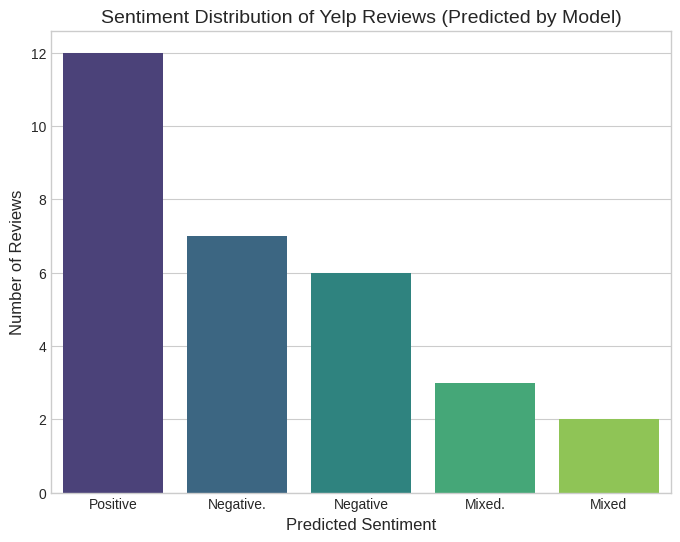


Initial Insight from Model's Prediction:
predicted_sentiment
Positive     12
Negative.     7
Negative      6
Mixed.        3
Mixed         2
Name: count, dtype: int64


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil sampel data untuk dianalisis (30 ulasan pertama)
sample_size = 30
data_sampel = dataset['train'].select(range(sample_size))
df = pd.DataFrame(data_sampel)
print(f"Starting sentiment classification for {sample_size} reviews...")
df['predicted_sentiment'] = df['text'].apply(klasifikasi_sentimen)
print("✅ Classification process finished.")
df['original_stars'] = df['label'].apply(convert_label_to_stars)
print("\nComparison of Original Stars and Predicted Sentiment:")
print(df[['text', 'original_stars', 'predicted_sentiment']].head())

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

sentiment_counts = df['predicted_sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", ax=ax)
ax.set_title('Sentiment Distribution of Yelp Reviews (Predicted by Model)', fontsize=14)
ax.set_xlabel('Predicted Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
plt.show()

print("\nInitial Insight from Model's Prediction:")
print(sentiment_counts)

# Bersihkan dan Kelompokkan Data
Fungsi untuk membersihkan dan mengelompokkan setiap hasil prediksi

--- Hasil Setelah Dibersihkan dan Dikelompokkan ---
kategori_bersih
Negative    13
Positive    12
Mixed        5
Name: count, dtype: int64


/tmp/ipython-input-2157421764.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_counts.index, y=final_counts.values, palette="viridis", ax=ax)


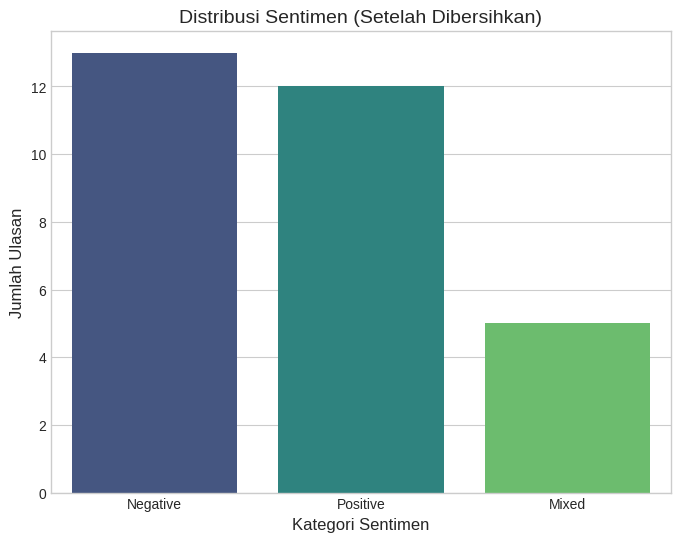

In [9]:
def bersihkan_kategori(kategori_prediksi):
    kategori = str(kategori_prediksi).lower().strip()
    if 'mixed' in kategori:
        return 'Mixed'
    elif 'positive' in kategori:
        return 'Positive'
    elif 'negative' in kategori:
        return 'Negative'
    elif 'neutral' in kategori:
        return 'Neutral'
    else:
        return 'Unknown'

df['kategori_bersih'] = df['predicted_sentiment'].apply(bersihkan_kategori)

print("--- Hasil Setelah Dibersihkan dan Dikelompokkan ---")
final_counts = df['kategori_bersih'].value_counts()
print(final_counts)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x=final_counts.index, y=final_counts.values, palette="viridis", ax=ax)

ax.set_title('Distribusi Sentimen (Setelah Dibersihkan)', fontsize=14)
ax.set_xlabel('Kategori Sentimen', fontsize=12)
ax.set_ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

# Insight & Findings
Menggunakan model AI (ibm-granite/granite-3.3-2b-instruct) untuk menghasilkan insight dari data agregat sentimen.

In [10]:
from IPython.display import display, Markdown

def generate_insights(counts):
    data_summary = "Berikut adalah hasil analisis sentimen dari 30 ulasan produk Yelp:\n"
    for category, count in counts.items():
        data_summary += f"- {category}: {count} ulasan\n"

    prompt = f"""
Task: You are a professional data analyst. Based on the following sentiment analysis data, write the "Insight & Findings" section for a business report.
The insights must be unique, logical, and comprehensive. Explain what these numbers mean from a business perspective. Provide at least 3 distinct insight points in a bulleted list.

Data:
{data_summary}

Insight & Findings:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.4,
        repetition_penalty=1.1
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    final_insight = result_text.split("Insight & Findings:")[-1].strip()

    return final_insight

print("🤖 Meminta AI untuk menghasilkan Insight & Findings...")
insight_hasil_ai = generate_insights(final_counts)
print("✅ Insight berhasil dibuat.")

display(Markdown("---"))
display(Markdown("## Insight & Findings (Dihasilkan oleh AI)"))
display(Markdown(insight_hasil_ai))

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Meminta AI untuk menghasilkan Insight & Findings...
✅ Insight berhasil dibuat.


---

## Insight & Findings (Dihasilkan oleh AI)

1. **Balanced Customer Feedback**: The sentiment analysis of product reviews on Yelp reveals a balanced customer feedback with 13 negative, 12 positive, and 5 mixed reviews. This indicates that customers have diverse experiences with the product, suggesting both strengths and areas for improvement.

2. **Potential for Product Enhancement**: With 13 negative reviews, there is an opportunity to address specific concerns raised by dissatisfied customers. Analyzing these reviews can help identify common issues or features that did not meet customer expectations, enabling the business to prioritize enhancements and refine its product offerings accordingly.

3. **Strong Satisfaction among Part of the Customer Base**: The high number of positive reviews (12) signifies that a significant portion of customers is satisfied with the product's performance. This finding emphasizes the importance of maintaining and leveraging these positive experiences to build brand loyalty and encourage repeat purchases. Additionally, understanding the nature of these positive reviews can provide valuable insights into successful product features and aspects that contribute to customer satisfaction.

By examining the distribution of positive, negative, and mixed reviews, this data-driven approach offers actionable insights for improving product quality

# Conclusion & Recommendation
Menggunakan model AI (ibm-granite/granite-3.3-2b-instruct) untuk menghasilkan kesimpulan dan rekomendasi berdasarkan insight yang sudah ada.

In [11]:
from IPython.display import display, Markdown

def generate_recommendations(insights_text):
    prompt = f"""
Task: You are a senior business consultant. Your task is to write the final "Conclusion & Recommendation" section for a report.
Use ONLY the "Insight & Findings" provided below as your context.
The recommendations must be concrete, actionable, and have a clear potential impact on the business.

Provided Insight & Findings:
---
{insights_text}
---

Based on the insights above, generate the "Conclusion & Recommendation" section. Structure it with:
1. A "Conclusion" paragraph that summarizes the overall situation.
2. A bulleted list under "Recommendations" with at least 3 actionable points.

Conclusion & Recommendation:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=300,
        temperature=0.5,
        repetition_penalty=1.1
    )

    result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    final_recommendation = result_text.split("Conclusion & Recommendation:")[-1].strip()

    return final_recommendation

if 'insight_hasil_ai' in locals():
    print("🤖 Meminta AI untuk menghasilkan Conclusion & Recommendation...")
    rekomendasi_hasil_ai = generate_recommendations(insight_hasil_ai)
    print("✅ Rekomendasi berhasil dibuat.")
    display(Markdown("---"))
    display(Markdown("## Conclusion & Recommendation (Dihasilkan oleh AI)"))
    display(Markdown(rekomendasi_hasil_ai))
else:
    print("Jalankan sel 'Insight & Findings' terlebih dahulu untuk menghasilkan insight.")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Meminta AI untuk menghasilkan Conclusion & Recommendation...
✅ Rekomendasi berhasil dibuat.


---

## Conclusion & Recommendation (Dihasilkan oleh AI)

---

In conclusion, our analysis of customer feedback from Yelp reveals a nuanced picture of product reception, characterized by a mix of positive, negative, and mixed experiences. While a substantial segment of customers expresses satisfaction with the product, there remains a notable proportion expressing dissatisfaction, indicating potential areas for enhancement.

**Recommendations:**

1. Prioritize Dissatisfied Customers' Concerns: Given the 13 negative reviews, it is imperative to conduct a thorough investigation into recurring issues or unmet expectations mentioned in these reviews. By addressing these concerns directly, the company can improve product quality and potentially win back dissatisfied customers.

2. Leverage Positive Reviews for Brand Loyalty: The 12 positive reviews highlight a strong foundation of customer satisfaction. To further strengthen brand loyalty, the company should actively seek testimonials and case studies from these satisfied customers, using them in marketing campaigns and customer communications to reinforce trust and encourage repeat purchases.

3. Analyze Mixed Reviews for Product Refinement: Although classified as mixed, these reviews may contain valuable insights for product refinement. Engage with customers who have mixed feelings to understand their expectations better and adjust product features or messaging accordingly to align more closely with customer needs.

Implementing these recommendations will enable the business to capitalize on